In [1]:
import sys, os
from pathlib import Path
import numpy as np
import cartesian_explorer as caex

def addpath(path):
    if str(path) not in sys.path:
        sys.path.insert(0, str(path))
        print(f"Added {path} to PYTHONPATH")

cwd = Path(os.path.abspath(""))
addpath(cwd.parent)
qtensor_path = Path(os.path.expanduser("~")) / "qsim" / "QTensor"
qtree_path = qtensor_path / "qtree"
addpath(qtensor_path)
addpath(qtree_path)

Added /home/danlkv/qsim/QTensor/bench/qc_simulation to PYTHONPATH
Added /home/danlkv/qsim/QTensor to PYTHONPATH
Added /home/danlkv/qsim/QTensor/qtree to PYTHONPATH


In [2]:
%load_ext autoreload
%autoreload 2

## Qtensor simulation functions

In [3]:

import json
import copy
import networkx as nx
import qtensor
import qtree
# qtensor simulation

# -- 1. Read circuit

def qtensor_read_circ(circ_f):
    """ Read Json representation of maxcut problem and return composer object """
    with open(str(circ_f), 'r') as f:
        data = f.read()
    data = json.loads(data)
    terms = data["terms"]
    gamma = np.array(data["gamma"])/np.pi/2
    beta = np.array(data["beta"])/np.pi
    N = len(set(sum([t[1] for t in terms], [])))
    G = nx.Graph()
    for factor, term in terms:
        G.add_edge(*term)
    composer = qtensor.DefaultQAOAComposer(G, gamma=gamma, beta=beta)
    return composer

qtensor_read_circ('../data/circuits/qaoa_maxcut_fixangle/3regfix_N30_p5.jsonterms')

2023-11-03 06:33:35.677477: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


/home/danlkv/qsim/QTensor/qtensor/compression/szx/src


In [4]:


# -- 2. Preprocess circuit

def qtensor_preprocess_tn(tn, mem_target, after_slice, ordering_algo):
    opt = qtensor.toolbox.get_ordering_algo(ordering_algo)
    # ignore argument type mismatch for pyright -- opt can be `Optimizer`
    # pyright: reportGeneralTypeIssues=false
    opt = qtensor.optimisation.TreeTrimSplitter(
        tw_bias=0, max_tw=mem_target, base_ordering=opt,
        peo_after_slice_strategy=after_slice
    )
    
    peo, par_vars, _ = opt.optimize(tn)
    #print("W", opt.treewidth)
    return (peo, par_vars, tn), opt.treewidth

def qtensor_preprocess(circ, mem_target,
            hardest_edges=5,
            number_edges=100,
            after_slice='run-again', 
            ordering_algo='greedy'
        ):
    """
    Preprocess energy calculation lightcones. Use `hardest_edges`
    """
    composer = circ
    G = composer.graph
    prep_data = []
    for edge in list(G.edges)[:number_edges]:
        c_copy = copy.deepcopy(composer)
        c_copy.energy_expectation_lightcone(edge)
        _tn = qtensor.optimisation.QtreeTensorNet.from_qtree_gates(c_copy.circuit)
        e_prep, width = qtensor_preprocess_tn(_tn, mem_target, after_slice, ordering_algo)
        prep_data.append((e_prep, width))
    # select only some largest-width edges
    selected = list(sorted(prep_data, key=lambda x: x[1], reverse=True))[:hardest_edges]
    prep_data = [x[0] for x in selected]
    return prep_data


prep_data = qtensor_preprocess(
    qtensor_read_circ('../data/circuits/qaoa_maxcut_fixangle/3regfix_N30_p5.jsonterms'),
    mem_target=25,
    hardest_edges=3,
    number_edges=3,
    after_slice='TD-reuse',
    ordering_algo='rgreedy_0.05_10'
)

2023-11-03 06:33:52.835 | INFO     | qtensor.optimisation.Optimizer:get_ordering_ints:262 - Maximum treewidth: 25
2023-11-03 06:33:53.351 | INFO     | qtensor.optimisation.Optimizer:_split_graph:322 - Treewidth: 39
2023-11-03 06:33:53.352 | INFO     | qtensor.optimisation.Optimizer:_split_graph:323 - Target treewidth: 25
2023-11-03 06:33:53.433 | INFO     | qtensor.optimisation.Optimizer:_split_graph:353 - Parvars count: 3. Amps count: 8
2023-11-03 06:33:53.540 | INFO     | qtensor.optimisation.Optimizer:_update_peo_after_slice:216 - Re-created peo width from tree: 36
2023-11-03 06:33:53.541 | INFO     | qtensor.optimisation.Optimizer:_update_peo_after_slice:229 - Treewidth after slice: 36
2023-11-03 06:33:53.618 | INFO     | qtensor.optimisation.Optimizer:_split_graph:353 - Parvars count: 6. Amps count: 64


# of components: 4, # of nodes total: 227, # of nodes per component: [224, 1, 1, 1]
Calling get_peo_from_tree
# of components:  4
# of components: 4, # of nodes total: 224, # of nodes per component: [221, 1, 1, 1]


2023-11-03 06:33:53.862 | INFO     | qtensor.optimisation.Optimizer:_update_peo_after_slice:216 - Re-created peo width from tree: 33
2023-11-03 06:33:53.863 | INFO     | qtensor.optimisation.Optimizer:_update_peo_after_slice:229 - Treewidth after slice: 33
2023-11-03 06:33:53.928 | INFO     | qtensor.optimisation.Optimizer:_split_graph:353 - Parvars count: 8. Amps count: 256
2023-11-03 06:33:54.016 | INFO     | qtensor.optimisation.Optimizer:_update_peo_after_slice:216 - Re-created peo width from tree: 31
2023-11-03 06:33:54.016 | INFO     | qtensor.optimisation.Optimizer:_update_peo_after_slice:229 - Treewidth after slice: 31


Calling get_peo_from_tree
# of components:  4
# of components: 4, # of nodes total: 222, # of nodes per component: [219, 1, 1, 1]
Calling get_peo_from_tree
# of components:  4


2023-11-03 06:33:54.079 | INFO     | qtensor.optimisation.Optimizer:_split_graph:353 - Parvars count: 10. Amps count: 1024
2023-11-03 06:33:54.161 | INFO     | qtensor.optimisation.Optimizer:_update_peo_after_slice:216 - Re-created peo width from tree: 29
2023-11-03 06:33:54.161 | INFO     | qtensor.optimisation.Optimizer:_update_peo_after_slice:218 - Re-created peo is better than old peo. Using new peo.
2023-11-03 06:33:54.162 | INFO     | qtensor.optimisation.Optimizer:_update_peo_after_slice:229 - Treewidth after slice: 29
2023-11-03 06:33:54.215 | INFO     | qtensor.optimisation.Optimizer:_split_graph:353 - Parvars count: 11. Amps count: 2048
2023-11-03 06:33:54.294 | INFO     | qtensor.optimisation.Optimizer:_update_peo_after_slice:216 - Re-created peo width from tree: 28
2023-11-03 06:33:54.294 | INFO     | qtensor.optimisation.Optimizer:_update_peo_after_slice:229 - Treewidth after slice: 28


# of components: 4, # of nodes total: 220, # of nodes per component: [217, 1, 1, 1]
Calling get_peo_from_tree
# of components:  4
# of components: 4, # of nodes total: 219, # of nodes per component: [216, 1, 1, 1]
Calling get_peo_from_tree
# of components:  4


2023-11-03 06:33:54.347 | INFO     | qtensor.optimisation.Optimizer:_split_graph:353 - Parvars count: 12. Amps count: 4096
2023-11-03 06:33:54.423 | INFO     | qtensor.optimisation.Optimizer:_update_peo_after_slice:216 - Re-created peo width from tree: 27
2023-11-03 06:33:54.424 | INFO     | qtensor.optimisation.Optimizer:_update_peo_after_slice:229 - Treewidth after slice: 27


# of components: 5, # of nodes total: 218, # of nodes per component: [214, 1, 1, 1, 1]
Calling get_peo_from_tree
# of components:  5


2023-11-03 06:33:54.639 | INFO     | qtensor.optimisation.Optimizer:_split_graph:353 - Parvars count: 13. Amps count: 8192
2023-11-03 06:33:54.711 | INFO     | qtensor.optimisation.Optimizer:_update_peo_after_slice:216 - Re-created peo width from tree: 26
2023-11-03 06:33:54.711 | INFO     | qtensor.optimisation.Optimizer:_update_peo_after_slice:229 - Treewidth after slice: 26
2023-11-03 06:33:54.762 | INFO     | qtensor.optimisation.Optimizer:_split_graph:353 - Parvars count: 14. Amps count: 16384
2023-11-03 06:33:54.832 | INFO     | qtensor.optimisation.Optimizer:_update_peo_after_slice:216 - Re-created peo width from tree: 25
2023-11-03 06:33:54.833 | INFO     | qtensor.optimisation.Optimizer:_update_peo_after_slice:229 - Treewidth after slice: 25
2023-11-03 06:33:54.856 | INFO     | qtensor.optimisation.Optimizer:get_ordering_ints:262 - Maximum treewidth: 25
2023-11-03 06:33:55.497 | INFO     | qtensor.optimisation.Optimizer:_split_graph:322 - Treewidth: 42


# of components: 5, # of nodes total: 217, # of nodes per component: [213, 1, 1, 1, 1]
Calling get_peo_from_tree
# of components:  5
# of components: 6, # of nodes total: 216, # of nodes per component: [211, 1, 1, 1, 1, 1]
Calling get_peo_from_tree
# of components:  6


2023-11-03 06:33:55.497 | INFO     | qtensor.optimisation.Optimizer:_split_graph:323 - Target treewidth: 25
2023-11-03 06:33:55.601 | INFO     | qtensor.optimisation.Optimizer:_split_graph:353 - Parvars count: 4. Amps count: 16
2023-11-03 06:33:55.729 | INFO     | qtensor.optimisation.Optimizer:_update_peo_after_slice:216 - Re-created peo width from tree: 38
2023-11-03 06:33:55.730 | INFO     | qtensor.optimisation.Optimizer:_update_peo_after_slice:229 - Treewidth after slice: 38


# of components: 2, # of nodes total: 240, # of nodes per component: [239, 1]
Calling get_peo_from_tree
# of components:  2


2023-11-03 06:33:55.977 | INFO     | qtensor.optimisation.Optimizer:_split_graph:353 - Parvars count: 7. Amps count: 128
2023-11-03 06:33:56.091 | INFO     | qtensor.optimisation.Optimizer:_update_peo_after_slice:216 - Re-created peo width from tree: 35
2023-11-03 06:33:56.092 | INFO     | qtensor.optimisation.Optimizer:_update_peo_after_slice:229 - Treewidth after slice: 35
2023-11-03 06:33:56.175 | INFO     | qtensor.optimisation.Optimizer:_split_graph:353 - Parvars count: 10. Amps count: 1024


# of components: 3, # of nodes total: 237, # of nodes per component: [235, 1, 1]
Calling get_peo_from_tree
# of components:  3
# of components: 6, # of nodes total: 234, # of nodes per component: [229, 1, 1, 1, 1, 1]


2023-11-03 06:33:56.278 | INFO     | qtensor.optimisation.Optimizer:_update_peo_after_slice:216 - Re-created peo width from tree: 32
2023-11-03 06:33:56.278 | INFO     | qtensor.optimisation.Optimizer:_update_peo_after_slice:229 - Treewidth after slice: 32
2023-11-03 06:33:56.347 | INFO     | qtensor.optimisation.Optimizer:_split_graph:353 - Parvars count: 12. Amps count: 4096
2023-11-03 06:33:56.440 | INFO     | qtensor.optimisation.Optimizer:_update_peo_after_slice:216 - Re-created peo width from tree: 30
2023-11-03 06:33:56.441 | INFO     | qtensor.optimisation.Optimizer:_update_peo_after_slice:229 - Treewidth after slice: 30


Calling get_peo_from_tree
# of components:  6
# of components: 8, # of nodes total: 232, # of nodes per component: [1, 225, 1, 1, 1, 1, 1, 1]
Calling get_peo_from_tree
# of components:  8


2023-11-03 06:33:56.507 | INFO     | qtensor.optimisation.Optimizer:_split_graph:353 - Parvars count: 14. Amps count: 16384


# of components: 9, # of nodes total: 230, # of nodes per component: [1, 222, 1, 1, 1, 1, 1, 1, 1]
Calling get_peo_from_tree
# of components:  9


2023-11-03 06:33:56.764 | INFO     | qtensor.optimisation.Optimizer:_update_peo_after_slice:216 - Re-created peo width from tree: 28
2023-11-03 06:33:56.764 | INFO     | qtensor.optimisation.Optimizer:_update_peo_after_slice:229 - Treewidth after slice: 28
2023-11-03 06:33:56.821 | INFO     | qtensor.optimisation.Optimizer:_split_graph:353 - Parvars count: 15. Amps count: 32768
2023-11-03 06:33:56.905 | INFO     | qtensor.optimisation.Optimizer:_update_peo_after_slice:216 - Re-created peo width from tree: 27
2023-11-03 06:33:56.906 | INFO     | qtensor.optimisation.Optimizer:_update_peo_after_slice:229 - Treewidth after slice: 27
2023-11-03 06:33:56.961 | INFO     | qtensor.optimisation.Optimizer:_split_graph:353 - Parvars count: 16. Amps count: 65536
2023-11-03 06:33:57.043 | INFO     | qtensor.optimisation.Optimizer:_update_peo_after_slice:216 - Re-created peo width from tree: 26
2023-11-03 06:33:57.044 | INFO     | qtensor.optimisation.Optimizer:_update_peo_after_slice:229 - Treewid

# of components: 10, # of nodes total: 229, # of nodes per component: [1, 220, 1, 1, 1, 1, 1, 1, 1, 1]
Calling get_peo_from_tree
# of components:  10
# of components: 10, # of nodes total: 228, # of nodes per component: [1, 219, 1, 1, 1, 1, 1, 1, 1, 1]
Calling get_peo_from_tree
# of components:  10


2023-11-03 06:33:57.099 | INFO     | qtensor.optimisation.Optimizer:_split_graph:353 - Parvars count: 17. Amps count: 131072
2023-11-03 06:33:57.176 | INFO     | qtensor.optimisation.Optimizer:_update_peo_after_slice:216 - Re-created peo width from tree: 25
2023-11-03 06:33:57.177 | INFO     | qtensor.optimisation.Optimizer:_update_peo_after_slice:229 - Treewidth after slice: 25
2023-11-03 06:33:57.199 | INFO     | qtensor.optimisation.Optimizer:get_ordering_ints:262 - Maximum treewidth: 25
2023-11-03 06:33:57.830 | INFO     | qtensor.optimisation.Optimizer:_split_graph:322 - Treewidth: 44


# of components: 11, # of nodes total: 227, # of nodes per component: [1, 217, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Calling get_peo_from_tree
# of components:  11


2023-11-03 06:33:57.830 | INFO     | qtensor.optimisation.Optimizer:_split_graph:323 - Target treewidth: 25
2023-11-03 06:33:58.093 | INFO     | qtensor.optimisation.Optimizer:_split_graph:353 - Parvars count: 4. Amps count: 16
2023-11-03 06:33:58.229 | INFO     | qtensor.optimisation.Optimizer:_update_peo_after_slice:216 - Re-created peo width from tree: 40
2023-11-03 06:33:58.230 | INFO     | qtensor.optimisation.Optimizer:_update_peo_after_slice:229 - Treewidth after slice: 40
2023-11-03 06:33:58.324 | INFO     | qtensor.optimisation.Optimizer:_split_graph:353 - Parvars count: 8. Amps count: 256


# of components: 2, # of nodes total: 234, # of nodes per component: [233, 1]
Calling get_peo_from_tree
# of components:  2


2023-11-03 06:33:58.441 | INFO     | qtensor.optimisation.Optimizer:_update_peo_after_slice:216 - Re-created peo width from tree: 36
2023-11-03 06:33:58.442 | INFO     | qtensor.optimisation.Optimizer:_update_peo_after_slice:229 - Treewidth after slice: 36
2023-11-03 06:33:58.521 | INFO     | qtensor.optimisation.Optimizer:_split_graph:353 - Parvars count: 11. Amps count: 2048


# of components: 3, # of nodes total: 230, # of nodes per component: [228, 1, 1]
Calling get_peo_from_tree
# of components:  3
# of components: 5, # of nodes total: 227, # of nodes per component: [223, 1, 1, 1, 1]
Calling get_peo_from_tree
# of components:  5


2023-11-03 06:33:58.625 | INFO     | qtensor.optimisation.Optimizer:_update_peo_after_slice:216 - Re-created peo width from tree: 33
2023-11-03 06:33:58.625 | INFO     | qtensor.optimisation.Optimizer:_update_peo_after_slice:229 - Treewidth after slice: 33
2023-11-03 06:33:58.864 | INFO     | qtensor.optimisation.Optimizer:_split_graph:353 - Parvars count: 13. Amps count: 8192
2023-11-03 06:33:58.961 | INFO     | qtensor.optimisation.Optimizer:_update_peo_after_slice:216 - Re-created peo width from tree: 31
2023-11-03 06:33:58.961 | INFO     | qtensor.optimisation.Optimizer:_update_peo_after_slice:229 - Treewidth after slice: 31
2023-11-03 06:33:59.034 | INFO     | qtensor.optimisation.Optimizer:_split_graph:353 - Parvars count: 15. Amps count: 32768


# of components: 7, # of nodes total: 225, # of nodes per component: [219, 1, 1, 1, 1, 1, 1]
Calling get_peo_from_tree
# of components:  7
# of components: 8, # of nodes total: 223, # of nodes per component: [216, 1, 1, 1, 1, 1, 1, 1]
Calling get_peo_from_tree
# of components:  8


2023-11-03 06:33:59.123 | INFO     | qtensor.optimisation.Optimizer:_update_peo_after_slice:216 - Re-created peo width from tree: 29
2023-11-03 06:33:59.124 | INFO     | qtensor.optimisation.Optimizer:_update_peo_after_slice:229 - Treewidth after slice: 29
2023-11-03 06:33:59.183 | INFO     | qtensor.optimisation.Optimizer:_split_graph:353 - Parvars count: 16. Amps count: 65536
2023-11-03 06:33:59.269 | INFO     | qtensor.optimisation.Optimizer:_update_peo_after_slice:216 - Re-created peo width from tree: 28
2023-11-03 06:33:59.269 | INFO     | qtensor.optimisation.Optimizer:_update_peo_after_slice:229 - Treewidth after slice: 28
2023-11-03 06:33:59.330 | INFO     | qtensor.optimisation.Optimizer:_split_graph:353 - Parvars count: 17. Amps count: 131072
2023-11-03 06:33:59.413 | INFO     | qtensor.optimisation.Optimizer:_update_peo_after_slice:216 - Re-created peo width from tree: 27
2023-11-03 06:33:59.413 | INFO     | qtensor.optimisation.Optimizer:_update_peo_after_slice:229 - Treewi

# of components: 9, # of nodes total: 222, # of nodes per component: [214, 1, 1, 1, 1, 1, 1, 1, 1]
Calling get_peo_from_tree
# of components:  9
# of components: 9, # of nodes total: 221, # of nodes per component: [213, 1, 1, 1, 1, 1, 1, 1, 1]
Calling get_peo_from_tree
# of components:  9


2023-11-03 06:33:59.473 | INFO     | qtensor.optimisation.Optimizer:_split_graph:353 - Parvars count: 18. Amps count: 262144
2023-11-03 06:33:59.553 | INFO     | qtensor.optimisation.Optimizer:_update_peo_after_slice:216 - Re-created peo width from tree: 27
2023-11-03 06:33:59.553 | INFO     | qtensor.optimisation.Optimizer:_update_peo_after_slice:229 - Treewidth after slice: 26


# of components: 9, # of nodes total: 220, # of nodes per component: [212, 1, 1, 1, 1, 1, 1, 1, 1]
Calling get_peo_from_tree
# of components:  9


2023-11-03 06:33:59.788 | INFO     | qtensor.optimisation.Optimizer:_split_graph:353 - Parvars count: 19. Amps count: 524288
2023-11-03 06:33:59.864 | INFO     | qtensor.optimisation.Optimizer:_update_peo_after_slice:216 - Re-created peo width from tree: 26
2023-11-03 06:33:59.865 | INFO     | qtensor.optimisation.Optimizer:_update_peo_after_slice:229 - Treewidth after slice: 25


# of components: 9, # of nodes total: 219, # of nodes per component: [211, 1, 1, 1, 1, 1, 1, 1, 1]
Calling get_peo_from_tree
# of components:  9


In [5]:
prep_data[0][1]

[v_66,
 v_118,
 v_79,
 v_97,
 v_142,
 v_165,
 v_141,
 v_180,
 v_117,
 v_173,
 v_197,
 v_89,
 v_92,
 v_204]

In [6]:
# -- 3. Simulate

def qtensor_simulate(prep_data, 
             backend='einsum',
             compress=None,
             mem_target=29,
             r2r_error=1e-3, r2r_threshold=1e-3,
             **kwargs):
    import cupy
    cupy.cuda.profiler.start()

    C = dict(
        time=0,
        elapsed=0,
        memory=0,
        memory_history=[],
        nvmemory=0,
        result = dict(Re=0, Im=0),
        compression=dict(compress=[], decompress=[])
    )

    for prep_lightcone in prep_data[:5]:
        print(prep_lightcone)
        r = qtensor_simulate_preps_lightcone(prep_lightcone, backend, compress, mem_target,
                                              r2r_error,
                                              r2r_threshold,**kwargs)
        C['time'] += r['time']
        C['elapsed'] += r['elapsed']
        C['memory'] = max(C['memory'], r['memory'])
        C['nvmemory'] = max(C['nvmemory'], r['nvmemory'])
        C['memory_history'] += r['memory_history']
        C['result']['Re'] += r['result']['Re']
        C['result']['Im'] += r['result']['Im']
        if r.get('compression'):
            C['compression']['compress'] += r['compression']['compress']
            C['compression']['decompress'] += r['compression']['decompress']

    cupy.cuda.profiler.stop()
    return C


def qtensor_simulate_preps_lightcone(prep_data,
             backend='einsum',
             compress=None,
             mem_target=29,
             r2r_error=1e-3, r2r_threshold=1e-3,
             **kwargs):
    """
    Args:
        in_file: file with preprocessed data
        out_file: file to write the results to
        backend: backend to use
        compress: compression algorithm
        M: memory threshold for compression
        r2r_error: relative error for compression
        r2r_threshold: relative threshold for compression
    """
    import time
    from qtensor.contraction_algos import bucket_elimination
    from qtensor.compression.Compressor import CUSZCompressor, CUSZXCompressor, TorchCompressor, NEWSZCompressor
    #from qtensor.compression.Compressor import WriteToDiskCompressor
    import cupy
    peo, par_vars, tn = prep_data
    
    backend = qtensor.contraction_backends.get_backend(backend)
    if compress is not None:
        if compress == 'szx':
            print(f"{r2r_error=} {r2r_threshold=}")
            compressor = CUSZXCompressor(r2r_error=r2r_error, r2r_threshold=r2r_threshold)
            compressor = qtensor.compression.ProfileCompressor(compressor)
        elif compress == 'cusz':
            print(f"{r2r_error=} {r2r_threshold=}")
            compressor = CUSZCompressor(r2r_error=r2r_error, r2r_threshold=r2r_threshold)
            compressor = qtensor.compression.ProfileCompressor(compressor)
        elif compress == 'torch':
            print(f"{r2r_error=} {r2r_threshold=}")
            compressor = TorchCompressor(r2r_error=r2r_error, r2r_threshold=r2r_threshold)
            compressor = qtensor.compression.ProfileCompressor(compressor)
        elif compress == 'newsz':
            print(f"{r2r_error=} {r2r_threshold=}")
            compressor = NEWSZCompressor(r2r_error=r2r_error, r2r_threshold=r2r_threshold)
            compressor = qtensor.compression.ProfileCompressor(compressor)
        elif compress == 'disk':
            compressor = WriteToDiskCompressor(f'/grand/QTensor/compression/data/tensors_compressed_M{mem_target}/')
            compressor = qtensor.compression.ProfileCompressor(compressor)
        else:
            raise ValueError(f"Unknown compression algorithm: {compress}")
        backend = qtensor.contraction_backends.CompressionBackend(backend, compressor, mem_target)
        from qtensor.contraction_backends.performance_measurement_decorator import MemProfBackend
        backend = MemProfBackend(backend)

    relabelid = {}
    for tensor in tn.tensors:
        for i in tensor.indices:
            relabelid[int(i)] = i

    slice_ext = {relabelid[int(i)]: 0 for i in par_vars}

    if len(par_vars) > 0:
        print("Parvars", par_vars)
        print(f"Detected {len(par_vars)} slice variables")
    sim = qtensor.QtreeSimulator(backend=backend)
    sim.tn = tn
    sim.tn.backend = backend
    sim.peo = peo
    sim._slice_relabel_buckets(slice_ext)
    buckets = sim.tn.buckets
    # --dbg
    #ignore_vars  = sim.tn.bra_vars + sim.tn.ket_vars 
    #graph = qtree.graph_model.importers.buckets2graph(buckets, ignore_vars)
    #graph, label_dict = qtree.graph_model.relabel_graph_nodes(
        #graph, dict(zip(graph.nodes, np.array(list(graph.nodes)) - 127*2))
    #) 
    #import networkx as nx
    #components = list(nx.connected_components(graph))
    #print(f"Sliced graph # nodes: {graph.number_of_nodes()} and #components: {len(components)} with sizes {[len(c) for c in components]}")
    #print(f"peo size without par_vars and ignore_vars: {len(peo) - len(ignore_vars)}")
    # --

    start = time.time()
    for i in range(2**0):
        print(f"P {i}", end='', flush=True)
        bcopy = [b[:] for b in buckets]
        res = bucket_elimination(
            bcopy, backend,
            n_var_nosum=len(tn.free_vars)
        )
        del bcopy
        print("Result", res.data.flatten()[0])
        #time.sleep(0.5)
    sim_result = backend.get_result_data(res).flatten()[0]
    print("Simulation result:", sim_result)
    end = time.time()
    print("Elapsed", end - start)
    C = {'time': 2**len(par_vars)*(end - start)}
    C['elapsed'] = (end - start)
    C['memory'] = backend.max_mem
    C['memory_history'] = backend.mem_history
    C['nvmemory'] = backend.nvsmi_max_mem
    C['result'] = {
        "Re": np.real(sim_result).tolist(),
        "Im": np.imag(sim_result).tolist()
    }
    if compress is not None:
        if isinstance(compressor, qtensor.compression.ProfileCompressor):
            C['compression'] = compressor.get_profile_data_json()
    return C

In [7]:
info = qtensor_simulate(prep_data,
    backend='cupy',
    compress='szx',
    mem_target=24
)

([i_0, i_1, i_2, i_3, i_4, i_5, i_6, i_7, i_8, i_9, i_10, i_11, i_12, i_13, i_14, i_15, i_16, i_17, i_18, i_19, i_20, i_21, i_22, i_23, i_24, i_25, i_26, i_27, i_28, i_29, o_0, o_1, o_2, o_3, o_4, o_5, o_6, o_7, o_8, o_9, o_10, o_11, o_12, o_13, o_14, o_15, o_16, o_17, o_18, o_19, o_20, o_21, o_22, o_23, o_24, o_25, o_26, o_27, o_28, o_29, v_33, v_40, v_248, v_47, v_233, v_251, v_39, v_37, v_57, v_41, v_231, v_240, v_235, v_242, v_241, v_256, v_232, v_254, v_234, v_258, v_236, v_230, v_52, v_34, v_48, v_53, v_245, v_238, v_243, v_249, v_252, v_51, v_237, v_45, v_239, v_30, v_255, v_259, v_44, v_250, v_55, v_54, v_59, v_56, v_50, v_244, v_43, v_42, v_46, v_32, v_246, v_38, v_31, v_247, v_257, v_58, v_159, v_158, v_138, v_96, v_225, v_126, v_145, v_202, v_98, v_83, v_74, v_210, v_85, v_151, v_61, v_220, v_214, v_156, v_136, v_62, v_78, v_149, v_229, v_88, v_211, v_205, v_150, v_124, v_68, v_155, v_87, v_146, v_147, v_154, v_112, v_222, v_131, v_209, v_129, v_70, v_77, v_157, v_208, v_130

# Benchmarking setup

In [8]:
import pickle
ex = caex.Explorer(cache=caex.caches.JobLibCache('/tmp/qtensor/bench'))

@ex.provider
def circuit(circ_f, sim='qtensor'):
    return qtensor_read_circ(circ_f)

@ex.provider
def preprocess(circuit, mem_target, hardest_edges, sim_prep_args, number_edges=10, sim='qtensor'):
    if sim_prep_args.get('prep_file') is not None:
        with open(sim_prep_args['prep_file'], 'rb') as f:
            prep_data = pickle.load(f)
            print("Loaded prep data from", sim_prep_args['prep_file'])
        return prep_data
    return qtensor_preprocess(circuit, mem_target,
                              hardest_edges=hardest_edges,
                              number_edges=number_edges,
                              after_slice=sim_prep_args.get('after_slice', 'TD-reuse'),
                              ordering_algo=sim_prep_args.get('ordering_algo', 'greedy'),
                              )

@ex.provider
def sim_info(preprocess, sim_mem_target, sim_sim_args={}, sim='qtensor'):
    res =  qtensor_simulate(preprocess,
        mem_target=sim_mem_target,
        backend=sim_sim_args.get('backend', 'cupy'),
        compress=sim_sim_args.get('compress', 'szx'),
        r2r_error=sim_sim_args.get('r2r_error', 1e-3),
        r2r_threshold=sim_sim_args.get('r2r_threshold', 1e-3),
    )
    #print(preprocess)
    for i in preprocess:
        i[2].backend = None
    return [res]


@ex.provider
def memory(sim_info):
    return sim_info[0]['memory']

@ex.provider
def time(sim_info):
    return sim_info[0]['time']


In [9]:

@ex.provider
def nvmem(sim_info):
    return sim_info[0]['nvmemory']

@ex.provider
def result(sim_info):
    return sim_info[0]['result']['Re'] + 1j*sim_info[0]['result']['Im']

@ex.provider
def total_slices(preprocess):
    return sum([len(k[1]) for k in preprocess])

@ex.provider
def width(sim_info):
    w = max([max(s['tensors_sizes']) for s in sim_info[0]['memory_history']])
    return w

In [16]:
input_circ = '../data/circuits/qaoa_maxcut_fixangle/3regfix_N30_p5.jsonterms'
preprocess_data = '/home/danlkv/qsim/QTensor/bench/qc_simulation/data/preprocess/compress/qaoa_e/3regfix_N54_p4.jsonterms_Ogreedy_M29'
sim_prep_args_test = [
    dict( after_slice='TD-reuse', ordering_algo='rgreedy_0.02_10', prep_file=preprocess_data),
    dict( after_slice='run-again', ordering_algo='rgreedy_0.02_10', prep_file=preprocess_data),
]
sim_sim_args_test = [
    dict( backend='cupy', compress='szx',)
                     ]
args_test = dict(
    circ_f=[input_circ],
    mem_target=[29,28],
    sim_mem_target=[28, 27, 25],
    hardest_edges=[3],
    number_edges=[10],
    sim_prep_args=sim_prep_args_test,
    sim_sim_args=sim_sim_args_test,
)
    
res = ex.get_variables_xarray(('result','total_slices','memory', 'nvmem', 'time'), **args_test)

  0%|          | 0/12 [00:00<?, ?it/s]

_dimcount 4


In [17]:
res.attrs['preprocess_data'] = preprocess_data
res[2]

<xarray.DataArray (mem_target: 2, sim_mem_target: 3, sim_prep_args: 2)>
array([[[5.43685171e+09+0.j, 5.43685171e+09+0.j],
        [2.75249715e+09+0.j, 2.75249715e+09+0.j],
        [1.14188442e+09+0.j, 1.14188442e+09+0.j]],

       [[5.43685171e+09+0.j, 5.43685171e+09+0.j],
        [2.75249715e+09+0.j, 2.75249715e+09+0.j],
        [1.14188442e+09+0.j, 1.14188442e+09+0.j]]])
Coordinates:
    varname         <U12 'memory'
  * mem_target      (mem_target) int64 29 28
  * sim_mem_target  (sim_mem_target) int64 28 27 25
  * sim_prep_args   (sim_prep_args) object {'after_slice': 'TD-reuse', 'order...
Attributes:
    preprocess_data:  /home/danlkv/qsim/QTensor/bench/qc_simulation/data/prep...

In [21]:
sim_info_probe = ex.get_variable('sim_info',
                    circ_f='../data/circuits/qaoa_maxcut_fixangle/3regfix_N30_p5.jsonterms',
                    mem_target=29, sim_mem_target=25, sim_prep_args=sim_prep_args_test[0],
                    sim_sim_args=sim_sim_args_test[0],
                    hardest_edges=3,
                    number_edges=10,
                    )

preprocess_probe = ex.get_variable('preprocess',
                    circ_f='../data/circuits/qaoa_maxcut_fixangle/3regfix_N30_p5.jsonterms',
                    mem_target=29, sim_mem_target=25,
                    sim_prep_args=sim_prep_args_test[1],
                    sim_sim_args=sim_sim_args_test[0],
                    hardest_edges=3,
                    number_edges=10,
                    )

In [22]:
preprocess_probe[0][1]

[]

In [23]:
max([max(s['tensors_sizes']) for s in sim_info_probe[0]['memory_history']])

28

In [24]:
ex.cache.clear(sim_info)

In [25]:

sim_prep_args_slice = [
    dict( after_slice='TD-reuse', ordering_algo='rgreedy_0.02_20', prep_file=preprocess_data),
]
sim_sim_args_slice = [
    dict( backend='cupy', compress='szx',)
                     ]

args_slice = dict(
    circ_f=['../data/circuits/qaoa_maxcut_fixangle/3regfix_N30_p5.jsonterms'],
    mem_target=[28, 27, 26, 25],
    sim_mem_target=[29],
    hardest_edges=[3],
    number_edges=[10],
    sim_prep_args=sim_prep_args_slice,
    sim_sim_args=sim_sim_args_slice,
)
    
res_slice = ex.get_variables_xarray(('width', 'total_slices', 'memory', 'time'), **args_slice)

  0%|          | 0/4 [00:00<?, ?it/s]

Loaded prep data from /home/danlkv/qsim/QTensor/bench/qc_simulation/data/preprocess/compress/qaoa_e/3regfix_N54_p4.jsonterms_Ogreedy_M29
([i_0, i_1, i_2, i_3, i_4, i_5, i_6, i_7, i_8, i_9, i_10, i_11, i_12, i_13, i_14, i_15, i_16, i_17, i_18, i_19, i_20, i_21, i_22, i_23, i_24, i_25, i_26, i_27, i_28, i_29, i_30, i_31, i_32, i_33, i_34, i_35, o_0, o_1, o_2, o_3, o_4, o_5, o_6, o_7, o_8, o_9, o_10, o_11, o_12, o_13, o_14, o_15, o_16, o_17, o_18, o_19, o_20, o_21, o_22, o_23, o_24, o_25, o_26, o_27, o_28, o_29, o_30, o_31, o_32, o_33, o_34, o_35, v_36, v_37, v_38, v_39, v_40, v_41, v_42, v_43, v_44, v_45, v_46, v_47, v_48, v_49, v_50, v_51, v_52, v_53, v_54, v_55, v_56, v_57, v_58, v_59, v_60, v_61, v_62, v_63, v_64, v_65, v_66, v_67, v_68, v_69, v_70, v_71, v_227, v_225, v_222, v_219, v_218, v_217, v_216, v_211, v_210, v_206, v_204, v_205, v_207, v_208, v_209, v_212, v_213, v_214, v_215, v_220, v_221, v_223, v_224, v_226, v_228, v_229, v_230, v_231, v_232, v_233, v_234, v_235, v_236, v_

/home/danlkv/.local/polaris/conda/2023-01-10-unstable/lib/python3.10/site-packages/cartesian_explorer/Explorer.py:228: UserWarning: Persisting input arguments took 1.77s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  retval = f(**call_kwd)
/home/danlkv/.local/polaris/conda/2023-01-10-unstable/lib/python3.10/site-packages/cartesian_explorer/Explorer.py:228: UserWarning: Persisting input arguments took 1.73s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's t

Loaded prep data from /home/danlkv/qsim/QTensor/bench/qc_simulation/data/preprocess/compress/qaoa_e/3regfix_N54_p4.jsonterms_Ogreedy_M29
Loaded prep data from /home/danlkv/qsim/QTensor/bench/qc_simulation/data/preprocess/compress/qaoa_e/3regfix_N54_p4.jsonterms_Ogreedy_M29
Loaded prep data from /home/danlkv/qsim/QTensor/bench/qc_simulation/data/preprocess/compress/qaoa_e/3regfix_N54_p4.jsonterms_Ogreedy_M29
_dimcount 2


In [26]:
res.attrs['preprocess_data'] = preprocess_data
res_slice

<xarray.DataArray (varname: 4, mem_target: 4)>
array([[2.80000000e+01, 2.80000000e+01, 2.80000000e+01, 2.80000000e+01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [7.58433536e+09, 7.58433536e+09, 7.58433536e+09, 7.58433536e+09],
       [4.17125225e+00, 4.17125225e+00, 4.17125225e+00, 4.17125225e+00]])
Coordinates:
  * varname     (varname) <U12 'width' 'total_slices' 'memory' 'time'
  * mem_target  (mem_target) int64 28 27 26 25

Text(0, 0.5, 'Memory, b')

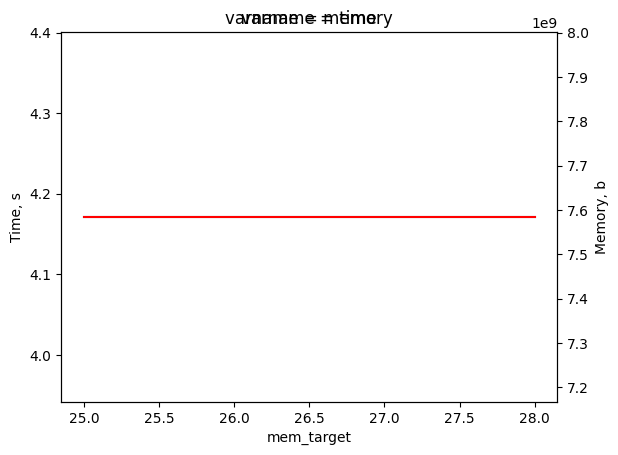

In [27]:
import matplotlib.pyplot as plt
res_slice.sel(varname='time').plot(x='mem_target')
plt.ylabel('Time, s')
plt.twinx()
res_slice.sel(varname='memory').plot(x='mem_target', c='red')
plt.ylabel('Memory, b')

In [28]:
import xarray
res_slice.to_netcdf('../data/run_slicing_results2.nc')